In [1]:
import os
import pandas as pd
import numpy as np
import pathlib
import pickle
import matplotlib.pyplot as plt
import copy

# Parameters

In [2]:
file_path = '/Users/zhangxun/data/robust_scheduling/det_release/num_jobs_random_coef_RS_1.08/'
with open(file_path + 'para_info.pkl','rb') as tf:
    para = pickle.load(tf)
delta_mu = para['delta_mu'] # control lb of mean processing time
delta_r = para['delta_r'] # control ub of the release time
delta_ep = para['delta_ep'] # control the upper bound of the mad
S_train = para['S_train']
S_test = para['S_test']
iterations = para['iterations']
instances = para['instances']
range_c = para['range_c']

In [3]:
def load_results(instances,project_path,file_name):
    rst_mean = np.zeros(instances)
    rst_75 = np.zeros(instances)
    rst_95 = np.zeros(instances)
    time_arr = np.zeros(instances)
    for ins in range(instances):
        full_path = project_path + 'ins='+str(ins)+'/' + 'iteration='+str(0)+'/'
        # print(full_path)
        # deterministic results
        with open(full_path+file_name, "rb") as tf:
            sol = pickle.load(tf)
        rst_mean[ins] = np.mean(sol['out_obj'])
        rst_75[ins] = np.quantile(sol['out_obj'],0.75)
        rst_95[ins] = np.quantile(sol['out_obj'],0.95)
        time_arr[ins] = sol['time']
    rst = {}
    rst['avg'] = rst_mean
    rst['quan_75'] = rst_75
    rst['quan_95'] = rst_95
    rst['time_arr'] = time_arr
    
    return rst


In [4]:
def load_wass_results(instances,range_c,project_path,file_name):
    len_c = len(range_c)
    obj_opt = np.zeros((instances,len_c))
    avg = np.zeros((instances,len_c))
    quan75 = np.zeros((instances,len_c))
    quan95 = np.zeros((instances,len_c))
    time_arr = np.zeros((instances,len_c))
    for ins in range(instances):
        full_path = project_path + 'ins='+str(ins)+'/' + 'iteration='+str(0)+'/'
        # print(full_path)
        # deterministic results
        with open(full_path+file_name, "rb") as tf:
            sol = pickle.load(tf)
        obj_opt[ins,:] = np.asarray(sol['out_obj'].mean(axis=0))
        avg[ins,:] = np.asarray(sol['out_obj'].mean(axis=0))
        quan75[ins,:] = np.asarray(sol['out_obj'].quantile(axis = 0,q = 0.75))
        quan95[ins,:] = np.asarray(sol['out_obj'].quantile(axis = 0,q = 0.95))
        time_arr[ins,:] = sol['time']
    rst = {}
    rst['avg'] = avg
    rst['quan_75'] = quan75
    rst['quan_95'] = quan95
    rst['time_arr'] = time_arr
    return rst

# Impact of processing time variance

In [63]:
file_path = '/Users/zhangxun/data/robust_scheduling/det_release/release_range_processing_var_RS/'
delta_r_all = np.asarray([0.05,0.15,0.3])
delta_ep_all = np.arange(0.5,1.51,0.5)
det_rst = np.zeros((len(delta_r_all),len(delta_ep_all)))
mm_rst = np.zeros((len(delta_r_all),len(delta_ep_all)))
saa_rst = np.zeros((len(delta_r_all),len(delta_ep_all)))
wass_rst = {}
metric_name = 'avg'
for i in range(len(delta_r_all)):
    delta_r = delta_r_all[i]
    for j in range(len(delta_ep_all)):
        delta_ep = delta_ep_all[j]
        print('delta_r=',delta_r,' delta_ep=',delta_ep)
        file_path1 = file_path + 'delta_r='+str(delta_r) + '/delta_ep='+str(delta_ep)+ '/'
        det_rst[i,j] = np.mean(load_results(instances,file_path1,'sol_det.pkl')[metric_name])
        saa_rst[i,j] = np.mean(load_results(instances,file_path1,'sol_saa.pkl')[metric_name])
        mm_rst[i,j] = np.mean(load_results(instances,file_path1,'sol_mom.pkl')[metric_name])
        wass_rst[i,j] = np.mean(load_wass_results(instances,range_c,file_path1,'sol_wass_exact.pkl')[metric_name],axis = 0)


delta_r= 0.05  delta_ep= 0.5
delta_r= 0.05  delta_ep= 1.0
delta_r= 0.05  delta_ep= 1.5
delta_r= 0.15  delta_ep= 0.5
delta_r= 0.15  delta_ep= 1.0
delta_r= 0.15  delta_ep= 1.5
delta_r= 0.3  delta_ep= 0.5
delta_r= 0.3  delta_ep= 1.0
delta_r= 0.3  delta_ep= 1.5


In [64]:
wass_rst

{(0,
  0): array([9287.74042411, 9324.04105078, 9374.87881437, 9396.76563396,
        9413.76026948, 9418.07138229, 9462.30499266, 9641.46606195,
        9979.13615944, 9979.13615944]),
 (0,
  1): array([9367.12168437, 9387.12577578, 9415.88148531, 9442.68234626,
        9460.94572153, 9474.11022635, 9504.37985931, 9512.91814242,
        9568.4838095 , 9694.79491758]),
 (0,
  2): array([9482.34698894, 9470.51861762, 9498.13449997, 9508.82107492,
        9515.21390796, 9526.73219811, 9542.7780899 , 9539.7737716 ,
        9544.10609998, 9578.96123117]),
 (1,
  0): array([ 9335.2375652 ,  9364.38616911,  9395.21203248,  9437.43273392,
         9469.77976388,  9475.6614415 ,  9571.4543695 ,  9828.47520356,
        10561.46280451, 10785.17168776]),
 (1,
  1): array([ 9381.8321884 ,  9381.03528174,  9416.62350429,  9442.12010738,
         9475.65889431,  9499.96288595,  9575.44646789,  9637.30450034,
         9842.9100718 , 10170.5387915 ]),
 (1,
  2): array([9497.17721358, 9508.34784683, 95

In [65]:
saa_rst

array([[9311.57333095, 9372.84256479, 9491.12866724],
       [9357.54558214, 9397.51201735, 9525.93908341],
       [9507.19277125, 9530.13951863, 9767.36567508]])

In [66]:
wass_rst[i,j]

array([ 9763.87436299,  9775.93283003,  9822.41721393,  9873.25753909,
        9947.9812512 ,  9995.82985865, 10089.03149869, 10143.40056532,
       10259.39587967, 10378.47692629])

In [67]:
# compute ratio
saa_ratio = saa_rst/det_rst
mm_ratio = mm_rst/det_rst
rs_ratio = {}
for i in range(len(delta_r_all)):
    delta_r = delta_r_all[i]
    for j in range(len(delta_ep_all)):
        delta_ep = delta_ep_all[j]
        rs_ratio[i,j] = wass_rst[i,j]/det_rst[i,j]

ratio_set = {}
ratio_set['saa'] = saa_ratio
ratio_set['mm'] = mm_ratio
ratio_set['rs'] = rs_ratio

In [68]:
saa_ratio

array([[1.00239851, 0.99912377, 0.99831106],
       [1.00144297, 0.9963092 , 0.99296024],
       [0.99926306, 0.9932083 , 0.98908156]])

In [69]:
rs_ratio

{(0,
  0): array([0.99983288, 1.00374067, 1.0092134 , 1.01156954, 1.01339902,
        1.01386312, 1.0186249 , 1.03791174, 1.0742622 , 1.0742622 ]),
 (0,
  1): array([0.99851394, 1.00064633, 1.00371163, 1.00656854, 1.00851537,
        1.00991868, 1.01314535, 1.01405551, 1.01997869, 1.03344316]),
 (0,
  2): array([0.99738737, 0.99614322, 0.99904796, 1.00017201, 1.00084443,
        1.00205597, 1.00374373, 1.00342773, 1.00388342, 1.0075496 ]),
 (1,
  0): array([0.99905557, 1.00217505, 1.00547403, 1.00999248, 1.01345426,
        1.01408371, 1.02433546, 1.05184178, 1.13028599, 1.15422728]),
 (1,
  1): array([0.99464685, 0.99456236, 0.99833537, 1.00103848, 1.00459421,
        1.00717088, 1.01517353, 1.02173162, 1.04352959, 1.07826426]),
 (1,
  2): array([0.98996217, 0.99112657, 0.99301741, 0.99729619, 0.99914547,
        0.999183  , 0.9989297 , 1.00401294, 1.01356442, 1.02607105]),
 (2,
  0): array([0.99697476, 1.00117866, 1.00831537, 1.01174895, 1.01583407,
        1.016487  , 1.03616774, 1.

In [70]:
for i in range(3):
    rs_mat = np.zeros((3,len(range_c)))
    for j in range(3):
        rs_mat[j,:] = rs_ratio[i,j]
    df = pd.DataFrame(rs_mat)
    df['saa'] = saa_ratio[i,:]
    df['mm'] = mm_ratio[i,:]
    pd.DataFrame(df).to_csv(file_path + metric_name + 'ratio_delta_r='+str(delta_r_all[i])+'.csv')

    

In [52]:
df

,0,1,2,3,4,5,6,7,8,9,saa
0,0.996975,1.001179,1.008315,1.011749,1.015834,1.016487,1.036168,1.053555,1.092444,1.103739,0.999263
1,0.990460,0.993992,0.999881,1.002761,1.006106,1.007175,1.018509,1.028180,1.062298,1.097448,0.993208
2,0.988728,0.989949,0.994656,0.999805,1.007371,1.012217,1.021655,1.027160,1.038906,1.050965,0.989082


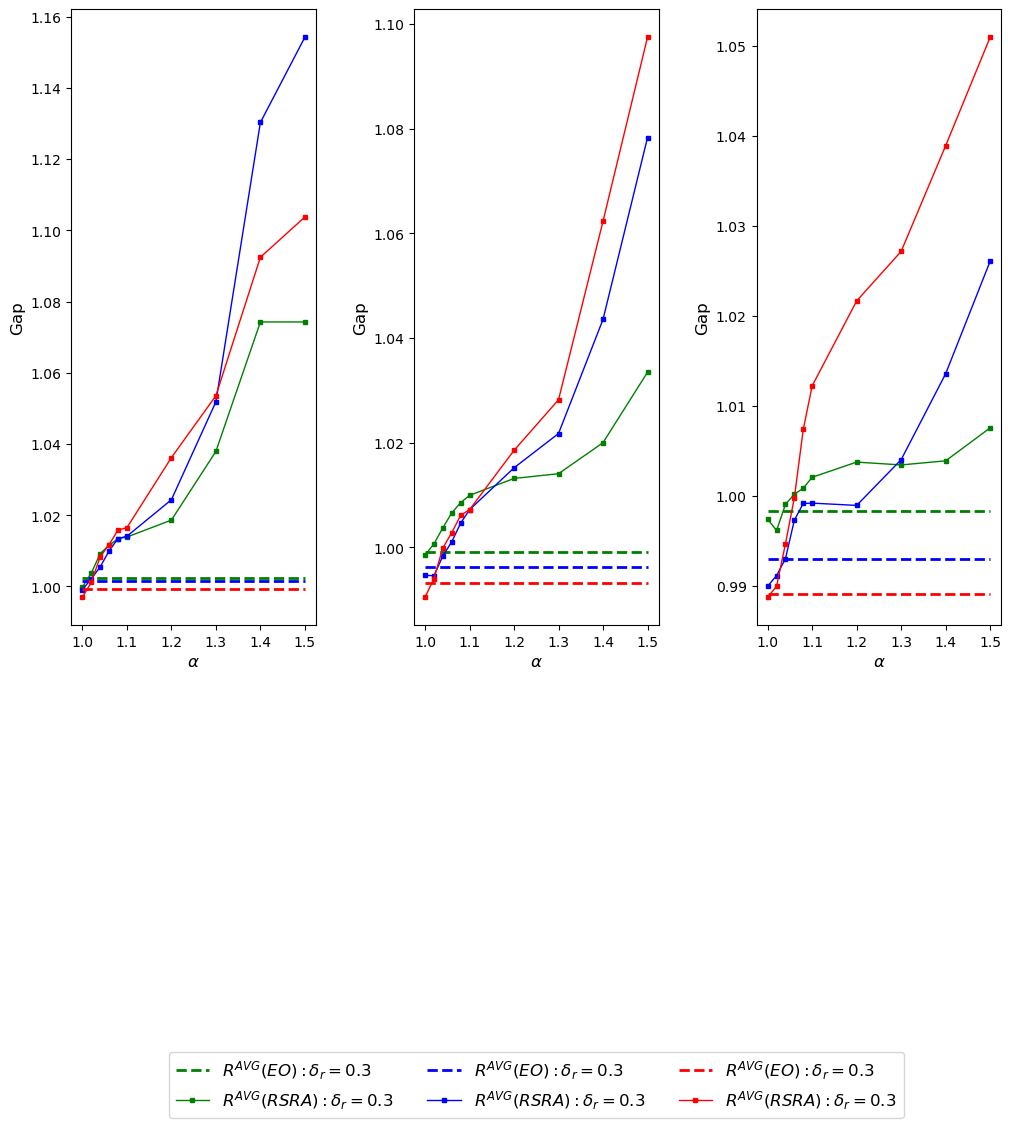

In [22]:
ms = 3
lw = 1
ticks = np.arange(1,1.501,0.1)
metric_name = 'avg'
color_set = ['g','b','r']
fig,ax = plt.subplots(1,3,figsize=(12, 8))
index = 0 
for j in range(len(delta_ep_all)):
    # ax[i,j].plot(range_c,np.ones(len(range_c)),'-.',color = 'k',linewidth = lw)
    if metric_name == 'avg':
        for k in range(len(delta_r_all)):
            name1 = r'$R^{AVG}(EO):\delta_r='+str(delta_r)+'$'
            name2 = r'$R^{AVG}(RSRA):\delta_r='+str(delta_r)+'$'
            ax[j].plot(range_c,np.ones(len(range_c))*ratio_set['saa'][k,j],'--',color = color_set[k],markersize=ms,linewidth = 2,label=name1)
            ax[j].plot(range_c,ratio_set['rs'][k,j],'-s',color = color_set[k],markersize=ms,linewidth = lw,label=name2)
    else:
        for k in range(len(delta_r_all)):
            delta_r = delta_r_all[k]
            name1 = r'$R^{PT}_{95}(EO):\delta_r='+str(delta_r)+'$'
            name2 = r'$R^{PT}_{95}(RSRA):\delta_r='+str(delta_r)+'$'
            ax[j].plot(range_c,np.ones(len(range_c))*ratio_set['saa'][k,j],'--',color = color_set[k],markersize=ms,linewidth = 2,label=name1)
            ax[j].plot(range_c,ratio_set['rs'][k,j],'-s',color = color_set[k],markersize=ms,linewidth = lw,label=name2)


    ax[j].set_ylabel('Gap',fontsize = 12)
    ax[j].set_xlabel(r'$\alpha$',fontsize = 12)
    # ax[i,j].set_yticks(np.arange(0.88,1.01,0.04))
    ax[j].set_xticks(ticks)
    # ax[j].set_title(r'$\delta^{r}_{\sigma}=$'+str(delta_er)+r', $\delta^{p}_{\sigma}=$'+str(delta_ep_all[j]))
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# ax.legend(loc='upper left',fontsize = 18) 
plt.legend(loc=8,fontsize = 12, ncol = 3, bbox_to_anchor=(-0.9,-0.8),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外
fig_name = 'Out-of-sample performance-'+metric_name+'.pdf'
plt.subplots_adjust(wspace =0.4, hspace =0.6)#调整子图间距
plt.savefig(file_path1 + fig_name, bbox_inches='tight') # 保存成PDF放大后不失真（默认保存在了当前文件夹下）
plt.show()


In [35]:
file_path1 = file_path + 'delta_ep=0.2/' 
rst_det= load_results(instances,file_path1,'sol_det.pkl')
rst_saa = load_results(instances,file_path1,'sol_saa.pkl')

In [39]:

def obtain_results(delta_all,name,file_name):
    rst_det = np.zeros((len(delta_all),instances))
    rst_saa = np.zeros((len(delta_all),instances))
    rst_mom = np.zeros((len(delta_all),instances))
    # rst_wass_exact = {}
    rst_wass_vns = {}
    for i in range(len(delta_all)):
        delta = delta_all[i]
        # print('delta_ep=',delta_ep,'-----------------------')
        file_path1 = file_name+str(delta) + '/'
        rst_det[i,:] = load_results(instances,file_path1,'sol_det.pkl')[name]
        rst_saa[i,:] = load_results(instances,file_path1,'sol_saa.pkl')[name]
        rst_mom[i,:] = load_results(instances,file_path1,'sol_mom.pkl')[name]
        rst_wass_vns[i] = load_wass_results(instances,range_c,file_path1,'sol_wass_exact.pkl')[name]
    return rst_det,rst_saa,rst_mom,rst_wass_vns

In [40]:
def obtain_avg_results(rst_det,rst_saa,rst_mom,rst_wass,delta_all):
    rst_det_avg = np.mean(rst_det,axis = 1)
    rst_saa_avg = np.mean(rst_saa,axis = 1)
    rst_mom_avg = np.mean(rst_mom,axis = 1)

    rst_wass_avg = np.zeros((len(delta_all),len(range_c)))
    for i in range(len(delta_all)):
        rst_wass_avg[i,:] = np.mean(rst_wass[i],axis = 0)/rst_det_avg[i]
    rst = pd.DataFrame(data=rst_wass_avg,columns=range_c)
    rst['saa'] = rst_saa_avg/rst_det_avg
    rst['mom'] = rst_mom_avg/rst_det_avg
    rst['det'] = rst_det_avg
    return rst

In [41]:
delta_ep_all = np.asarray([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])
file_name = file_path + 'delta_ep=' 
rst_det,rst_saa,rst_mom,rst_wass = obtain_results(delta_ep_all,'avg',file_name)
rst_avg = obtain_avg_results(rst_det,rst_saa,rst_mom,rst_wass,delta_ep_all)

In [42]:
rst_det,rst_saa,rst_mom,rst_wass = obtain_results(delta_ep_all,'quan_95',file_name)
rst_quan95 = obtain_avg_results(rst_det,rst_saa,rst_mom,rst_wass,delta_ep_all)

In [43]:
pd.DataFrame(rst_avg).to_csv(file_path + 'avg.csv')
pd.DataFrame(rst_quan95).to_csv(file_path + 'quan95.csv')

# Impact of release range

In [62]:
delta_r_all = np.asarray([0.05,0.1,0.15,0.2,0.25,0.3])
n = 20
# average performance
name = 'avg'
file_path1 = project_path + 'delta_r=0.05/' 
print(file_path1)
rst_det= load_results(instances,file_path1,'sol_det.pkl')



/Users/zhangxun/data/robust_scheduling/det_release/release_range_RS/delta_r=0.05/


In [67]:
file_name = project_path + 'delta_r=' 
rst_det,rst_saa,rst_mom,rst_wass =  obtain_results(delta_r_all,'avg',file_name)
rst_avg = obtain_avg_results(rst_det,rst_saa,rst_mom,rst_wass,delta_r_all)

In [68]:
rst_avg

,1.000001,1.01,1.02,1.03,1.04,1.05,1.06,1.08,1.1,1.12,...,1.18,1.2,1.22,1.24,1.26,1.28,1.3,saa,mom,det
0,0.991561,0.990976,0.991130,0.991514,0.992202,0.991540,0.990997,0.989680,0.989202,0.988205,...,0.986547,0.985776,0.984977,0.984254,0.983894,0.982777,0.982903,0.993342,1.000257,10554.114585
1,0.987096,0.986314,0.985737,0.985805,0.985782,0.985934,0.985402,0.987146,0.986646,0.985860,...,0.984784,0.984273,0.983769,0.983021,0.983315,0.989957,0.981876,0.989437,0.995602,10415.138292
2,0.982242,0.983079,0.983838,0.983894,0.984344,0.985008,0.984811,0.986060,0.986482,0.986892,...,0.988070,0.987758,0.985308,0.987860,0.986306,0.988205,0.989858,0.985061,0.995450,10647.535973
3,0.982928,0.983547,0.984343,0.985289,0.988551,0.987728,0.989276,0.993133,0.994219,0.993903,...,0.999467,0.999025,0.998745,0.999965,1.000675,1.001349,1.001162,0.985538,0.998184,10695.868544
4,0.979815,0.980304,0.981102,0.981472,0.983487,0.984747,0.985460,0.988878,0.990714,0.993007,...,0.997149,0.999460,1.000905,0.999343,0.999246,0.999790,0.999286,0.982817,0.994983,10740.958977
5,0.977222,0.978047,0.979147,0.980340,0.981250,0.983162,0.985495,0.992265,0.992941,0.996803,...,1.000377,1.004439,1.005777,1.010536,1.007576,1.012359,1.010303,0.980445,0.990669,10843.270920


In [69]:
rst_det,rst_saa,rst_mom,rst_wass =  obtain_results(delta_r_all,'quan_95',file_name)
rst_quan95 = obtain_avg_results(rst_det,rst_saa,rst_mom,rst_wass,delta_r_all)

In [70]:
pd.DataFrame(rst_avg).to_csv(project_path + 'avg.csv')
pd.DataFrame(rst_quan95).to_csv(project_path + 'quan95.csv')

# impact of number of jobs

In [5]:
name = 'avg'
file_path1 = file_path + 'n=10/' 
print(file_path1)
rst_det = load_results(instances,file_path1,'sol_det.pkl')
rst_affine =load_wass_results(instances,range_c,file_path1,'sol_wass_vns.pkl')

/Users/zhangxun/data/robust_scheduling/det_release/num_jobs_random_coef_RS_1.08/n=10/


In [200]:
file_path

'/Users/zhangxun/data/robust_scheduling/det_release/Exact_VS_Affine_random_coef_RS/'

In [122]:
rst_affine

{'avg': array([[2616.97412896, 2613.44958978, 2608.08110947, 2613.44958978,
         2608.08110947, 2608.08110947, 2608.08110947, 2608.08110947,
         2609.05982733, 2608.08110947, 2608.08110947, 2608.08110947,
         2608.08110947, 2608.08110947],
        [2561.75377663, 2561.75377663, 2561.75377663, 2631.32859184,
         2629.5229129 , 2629.5229129 , 2629.5229129 , 2629.5229129 ,
         2627.01686385, 2627.01686385, 2627.01686385, 2627.01686385,
         2627.01686385, 2627.01686385],
        [2637.1004046 , 2637.1004046 , 2637.1004046 , 2637.1004046 ,
         2644.71663449, 2702.49278419, 2770.59471934, 2774.17192311,
         2774.17192311, 2768.31478733, 2768.31478733, 2768.31478733,
         2768.31478733, 2768.31478733],
        [2663.5400088 , 2665.37615348, 2714.75796456, 2728.10673006,
         2744.24444085, 2738.18745723, 2738.27536631, 2733.77336159,
         2733.77336159, 2733.77336159, 2733.77336159, 2733.77336159,
         2733.77336159, 2733.77336159],
     

In [46]:
# N_all = [10,20,30]
# range_c = np.asarray([0])
def obtain_avg(N_all,metric_name):
    rst_det = np.zeros(len(N_all))
    rst_saa = np.zeros(len(N_all))
    rst_affine = np.zeros((len(N_all),len(range_c)))
    rst_exact = np.zeros((4,len(range_c)))
    rst_mm = np.zeros(4)
    for i in range(len(N_all)):
        n = N_all[i]
        file_path1 = file_path + 'n='+str(n) + '/'
        rst_det[i] = np.mean(load_results(instances,file_path1,'sol_det.pkl')[metric_name])
        rst_saa[i] = np.mean(load_results(instances,file_path1,'sol_saa.pkl')[metric_name])
        rst_affine[i] = np.mean(load_wass_results(instances,range_c,file_path1,'sol_wass_vns.pkl')[metric_name],axis = 0)
        if n <= 40:
            rst_exact[i] = np.mean(load_wass_results(instances,range_c,file_path1,'sol_wass_exact.pkl')[metric_name],axis = 0)
            rst_mm[i] = np.mean(load_results(instances,file_path1,'sol_mom.pkl')[metric_name])
    return rst_det,rst_saa,rst_affine,rst_exact,rst_mm



In [43]:
def obtain_ratio(N_all,rst_det,rst_saa,rst_affine,rst_exact,rst_mm):
    ratio_saa = np.zeros(len(N_all))
    ratio_mm = np.zeros(4)
    ratio_affine = np.zeros((len(N_all),len(range_c)))
    ratio_exact = np.zeros((4,len(range_c)))
    for i in range(len(N_all)):
        n = N_all[i]
        ratio_saa[i] = rst_saa[i]/rst_det[i]
        ratio_affine[i] = rst_affine[i,:]/rst_det[i]
        if i <= 3:
            ratio_mm[i] = rst_mm[i]/rst_det[i]
            ratio_exact[i] = rst_exact[i,:]/rst_det[i]

    # print('saa ratio:',np.round(ratio_saa,4))
    # print('affine ratio:',np.round(ratio_affine,4))
    return ratio_saa,ratio_affine,ratio_exact,ratio_mm

In [41]:
instances = 10
# range_c = [0]

In [47]:
N_all = [10,20,30,40,50,60,70,80]
metric_name = 'avg'
rst_det,rst_saa,rst_affine,rst_exact,rst_mm = obtain_avg(N_all,metric_name)
ratio_saa_avg,ratio_affine_avg,ratio_exact_avg,ratio_mm_avg = obtain_ratio(N_all,rst_det,rst_saa,rst_affine,rst_exact,rst_mm)

metric_name = 'quan_95'
rst_det,rst_saa,rst_affine,rst_exact,rst_mm = obtain_avg(N_all,metric_name)
ratio_saa_quan95,ratio_affine_quan95,ratio_exact_quan95,ratio_mm_quan95 = obtain_ratio(N_all,rst_det,rst_saa,rst_affine,rst_exact,rst_mm)

In [48]:
rst_mm

array([ 3411.66554348, 12130.78439156, 25886.23628824, 44444.23600822])

In [49]:
rst_df = pd.DataFrame()
rst_df['ratio_saa_avg'] = ratio_saa_avg
rst_df['ratio_affine_avg'] = ratio_affine_avg
rst_df['ratio_exact_avg'] = np.insert(np.zeros(len(ratio_saa_avg)-len(ratio_exact_avg[:,0])),0,ratio_exact_avg[:,0])
rst_df['ratio_mm_avg'] = np.insert(np.zeros(len(ratio_saa_avg)-len(ratio_exact_avg)),0,ratio_mm_avg)

rst_df['ratio_saa_quan95'] = ratio_saa_quan95
rst_df['ratio_affine_quan95'] = ratio_affine_quan95
rst_df['ratio_exact_quan95'] = np.insert(np.zeros(len(ratio_saa_avg)-len(ratio_exact_quan95[:,0])),0,ratio_exact_quan95[:,0])
rst_df['ratio_mm_quan95'] = np.insert(np.zeros(len(ratio_saa_avg)-len(ratio_exact_avg)),0,ratio_mm_quan95)

In [50]:
print('AVG MM ratio:',np.round(ratio_mm_avg,4),'95 MM ratio:',np.round(ratio_mm_quan95,4))
print('AVG EO ratio:',np.round(ratio_saa_avg,4),'95 EO ratio:',np.round(ratio_saa_quan95,4))
print('AVG Affine ratio:',np.round(ratio_affine_avg[:,0],4),'95 Affine ratio:',np.round(ratio_affine_quan95[:,0],4))

AVG MM ratio: [1.004  0.9981 0.9979 1.0005] 95 MM ratio: [1.0132 0.9946 0.9994 1.0009]
AVG EO ratio: [0.9964 0.994  0.993  0.9924 0.9942 0.9948 0.9953 0.9935] 95 EO ratio: [1.0003 0.9958 0.9954 0.9941 0.9952 0.9976 0.9974 0.9957]
AVG Affine ratio: [0.9925 0.9858 0.9869 0.9851 0.9881 0.9913 0.9913 0.9876] 95 Affine ratio: [0.9468 0.931  0.9444 0.954  0.9545 0.9606 0.9613 0.9583]


In [51]:
pd.DataFrame(rst_df).to_csv( file_path +'tft.csv')

In [52]:
metric_name = 'time_arr'
rst_det,rst_saa,rst_affine,rst_exact,rst_mm = obtain_avg(N_all,metric_name)


In [53]:
pd.DataFrame(rst_affine).to_csv( file_path +'time_affine.csv')
pd.DataFrame(rst_exact).to_csv( file_path +'time_exact.csv')


In [54]:
ratio_affine_quan95

array([[0.94679023],
       [0.93095475],
       [0.94436475],
       [0.95398991],
       [0.95449079],
       [0.96060904],
       [0.96126986],
       [0.95833364]])

In [56]:
rst_det = pd.DataFrame()
rst_saa = pd.DataFrame()
rst_mm = pd.DataFrame()
rst_affine = pd.DataFrame()
rst_exact = pd.DataFrame()
metric_name = 'time_arr'
for i in range(len(N_all)):
    n = N_all[i]
    file_path1 = file_path + 'n='+str(n) + '/'
    rst_det[n] = load_results(instances,file_path1,'sol_det.pkl')[metric_name]
    rst_saa[n] = load_results(instances,file_path1,'sol_saa.pkl')[metric_name]
    rst_affine[n] = load_wass_results(instances,range_c,file_path1,'sol_wass_vns.pkl')[metric_name][:,0]
    if n <= 40:
        rst_exact[n] = load_wass_results(instances,range_c,file_path1,'sol_wass_exact.pkl')[metric_name][:,0]
        rst_mm[n] = load_results(instances,file_path1,'sol_mom.pkl')[metric_name]

In [57]:
pd.DataFrame(rst_det).to_csv( file_path +'time_det.csv')
pd.DataFrame(rst_saa).to_csv( file_path +'time_saa.csv')
pd.DataFrame(rst_mm).to_csv( file_path +'time_mm.csv')
pd.DataFrame(rst_affine).to_csv( file_path +'time_affine.csv')
pd.DataFrame(rst_exact).to_csv( file_path +'time_exact.csv')

In [34]:
np.insert(np.zeros(len(ratio_saa_avg)-len(ratio_exact_avg)),0,ratio_mm_quan95)

array([0.99686622, 1.01099955, 1.00322225, 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [99]:
ratio_affine_avg

array([[0.99563761, 0.99563761, 0.99563761, 0.99563761, 0.99563761,
        0.99563761, 0.99563761, 0.99563761, 0.99563761, 0.99563761,
        0.99563761, 0.99563761, 0.99563761, 0.99563761],
       [0.99757433, 0.99757433, 0.99757433, 0.99757433, 0.99757433,
        0.99757433, 0.99757433, 0.99757433, 0.99757433, 0.99757433,
        0.99757433, 0.99757433, 0.99757433, 0.99757433],
       [0.992471  , 0.992471  , 0.992471  , 0.992471  , 0.992471  ,
        0.992471  , 0.992471  , 0.992471  , 0.992471  , 0.992471  ,
        0.992471  , 0.992471  , 0.992471  , 0.992471  ],
       [0.9903794 , 0.9903794 , 0.9903794 , 0.9903794 , 0.9903794 ,
        0.9903794 , 0.9903794 , 0.9903794 , 0.9903794 , 0.9903794 ,
        0.9903794 , 0.9903794 , 0.9903794 , 0.9903794 ],
       [0.98809914, 0.98809914, 0.98809914, 0.98809914, 0.98809914,
        0.98809914, 0.98809914, 0.98809914, 0.98809914, 0.98809914,
        0.98809914, 0.98809914, 0.98809914, 0.98809914],
       [0.98798805, 0.98798805, 0.9

In [105]:
ratio_exact_avg

array([[1.00391945],
       [0.99999987],
       [0.99504106]])

## plot impact of N

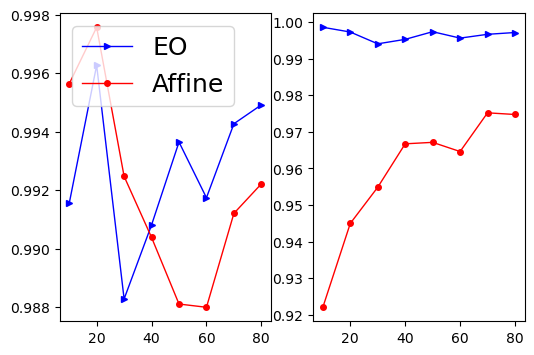

In [24]:
ms = 4
lw = 1

fig,ax = plt.subplots(1,2,figsize=(6, 4))
index = 0 
color_set = ['g','b','r']
# ax[0].plot(N_all,ratio_mm_avg,'-x',color = 'g',markersize=ms,linewidth = lw,label='MM')
ax[0].plot(N_all,ratio_saa_avg,'->',color = 'b',markersize=ms,linewidth = lw,label='EO')
ax[0].plot(N_all,ratio_affine_avg,'-o',color = 'r',markersize=ms,linewidth = lw,label='Affine')
# ax[0].plot(N_all,ratio_exact_avg,'-s',color = 'k',markersize=ms,linewidth = lw,label='Exact')

# ax[1].plot(N_all,ratio_mm_quan95,'-x',color = 'g',markersize=ms,linewidth = lw,label='MM')
ax[1].plot(N_all,ratio_saa_quan95,'->',color = 'b',markersize=ms,linewidth = lw,label='EO')
ax[1].plot(N_all,ratio_affine_quan95,'-o',color = 'r',markersize=ms,linewidth = lw,label='Affine')
# ax[1].plot(N_all,ratio_exact_quan95,'-s',color = 'k',markersize=ms,linewidth = lw,label='Exact')

        # ax[i,j].set_ylim(1.35,1.95)
# ax[0,0].set_ylabel('CVaR',fontsize = 18)
# ax[1,0].set_ylabel('CVaR',fontsize = 18)

# ax[0,0].set_title(r'Out-of-sample CVaR comparison when $S=63$')
# ax[0,1].set_title(r'Out-of-sample CVaR comparison when $S=126$')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

ax[0].legend(loc='upper left',fontsize = 18) 
# ax[0,1].legend(loc=2,fontsize = 12, bbox_to_anchor=(1.05,1),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外
# fig_name = 'CVaR (Num of stocks = %(n_x)s,epsilon=%(eps)s)'%{'n_x':n_x,'eps':stochOptForest_params['epsilon'][0]}
# plt.subplots_adjust(wspace =0.2, hspace =0.3)#调整子图间距
# plt.savefig(fig_name+'.pdf', bbox_inches='tight') # 保存成PDF放大后不失真（默认保存在了当前文件夹下）

plt.show()


In [17]:
index_arr = np.asarray([0,1,2,3,4,5,7,9,11,13])

range_c[index_arr]

array([1.000001, 1.02    , 1.04    , 1.06    , 1.08    , 1.1     ,
       1.2     , 1.3     , 1.4     , 1.5     ])

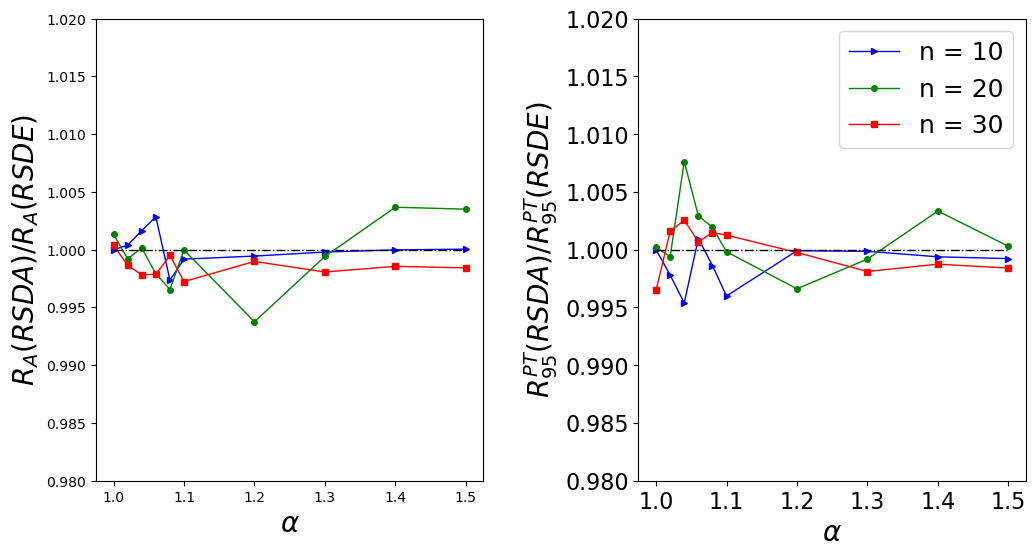

In [22]:
ms = 4
lw = 1

fig,ax = plt.subplots(1,2,figsize=(12, 6))
index = 0 
affine_color_set = ['b','g','r']
exact_color_set = ['r','m','k']

affine_shape_set = ['->','-o','-s']
exact_shape_set = ['-.>','-.o','-.s']
index_arr = np.asarray([0,1,2,3,4,5,7,9,11,13])
for i in range(len(N_all)):
        name1 = 'n = '+str(N_all[i])
        # name2 = 'Exact:'+str(N_all[i])
        # print('i=',i)
        ax[0].plot(range_c[index_arr],ratio_affine_avg[i][index_arr]/ratio_exact_avg[i][index_arr],affine_shape_set[i],color = affine_color_set[i],markersize=ms,linewidth = lw,label=name1)
        ax[1].plot(range_c[index_arr],ratio_affine_quan95[i][index_arr]/ratio_exact_quan95[i][index_arr],affine_shape_set[i],color = affine_color_set[i],markersize=ms,linewidth = lw,label=name1)
        # ax[0].plot(range_c,ratio_exact_avg[i],exact_shape_set[i],color = exact_color_set[i],markersize=ms,linewidth = lw,label=name2)
        # ax[1].plot(range_c,ratio_exact_quan95[i],exact_shape_set[i],color = exact_color_set[i],markersize=ms,linewidth = lw,label=name2)

ax[0].plot(range_c[index_arr],np.ones(len(range_c[index_arr])),'-.',color = 'k',markersize=ms,linewidth = lw)
ax[1].plot(range_c[index_arr],np.ones(len(range_c[index_arr])),'-.',color = 'k',markersize=ms,linewidth = lw)


ax[0].set_ylim(0.98,1.02)
ax[1].set_ylim(0.98,1.02)
ax[0].set_ylabel(r'$R_{A}(RSDA)/R_{A}(RSDE)$',fontsize = 20)
ax[1].set_ylabel(r'$R^{PT}_{95}(RSDA)/R^{PT}_{95}(RSDE)$',fontsize = 20)
ax[0].set_xlabel(r'$\alpha$',fontsize = 20)
ax[1].set_xlabel(r'$\alpha$',fontsize = 20)

# ax[0,0].set_title(r'Out-of-sample CVaR comparison when $S=63$')
# ax[0,1].set_title(r'Out-of-sample CVaR comparison when $S=126$')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax[1].legend(loc='upper right',fontsize = 18) 
# plt.subplots_adjust(hspace=0.2,wspace=0.3)

# ax[0,1].legend(loc=2,fontsize = 12, bbox_to_anchor=(1.05,1),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外
fig_name = 'Exact_vs_Affine.pdf'
plt.subplots_adjust(wspace =0.4, hspace =0.3)#调整子图间距
plt.savefig(file_path + fig_name, bbox_inches='tight') # 保存成PDF放大后不失真（默认保存在了当前文件夹下）

plt.show()


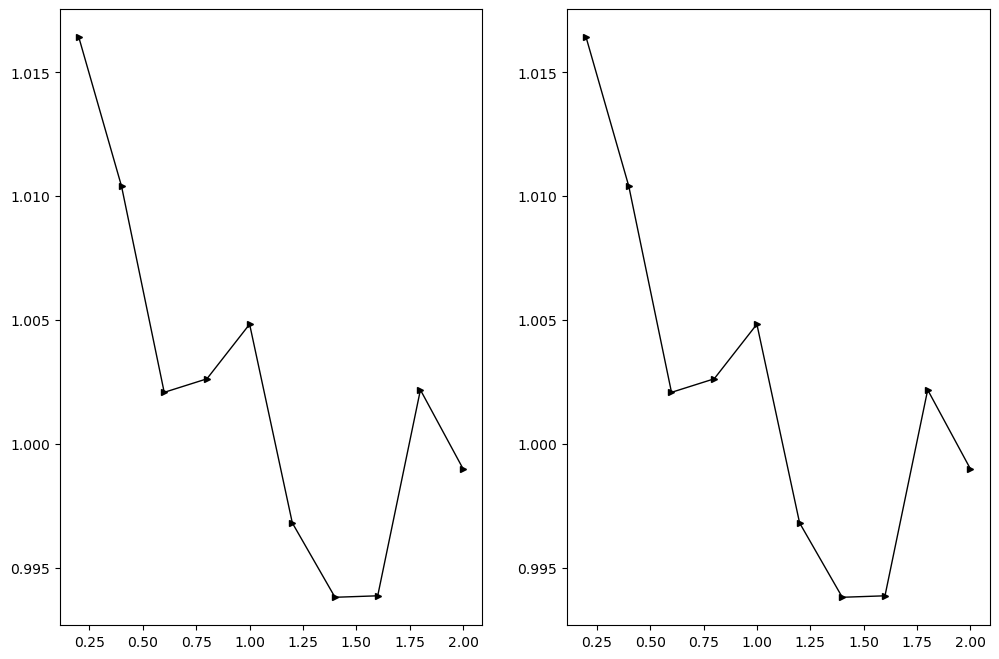

In [69]:
ms = 4
lw = 1

fig,ax = plt.subplots(1,2,figsize=(12, 8))
index = 0 
ax[0].plot(delta_ep_all,rst_mom_avg,'->',color = 'k',markersize=ms,linewidth = lw,label='Forest')
ax[0].plot(delta_ep_all,rst_saa_avg,'->',color = 'k',markersize=ms,linewidth = lw,label='Forest')

        # ax[i,j].set_ylim(1.35,1.95)
# ax[0,0].set_ylabel('CVaR',fontsize = 18)
# ax[1,0].set_ylabel('CVaR',fontsize = 18)

# ax[0,0].set_title(r'Out-of-sample CVaR comparison when $S=63$')
# ax[0,1].set_title(r'Out-of-sample CVaR comparison when $S=126$')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

# # ax.legend(loc='upper left',fontsize = 18) 
# ax[0,1].legend(loc=2,fontsize = 12, bbox_to_anchor=(1.05,1),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外
# fig_name = 'CVaR (Num of stocks = %(n_x)s,epsilon=%(eps)s)'%{'n_x':n_x,'eps':stochOptForest_params['epsilon'][0]}
# plt.subplots_adjust(wspace =0.2, hspace =0.3)#调整子图间距
# plt.savefig(fig_name+'.pdf', bbox_inches='tight') # 保存成PDF放大后不失真（默认保存在了当前文件夹下）

plt.show()


In [60]:
rst_det_avg

array([ 9679.80626105, 10342.68888164, 10841.70791293, 11198.11682387,
       11631.42340535, 12135.09741742, 12557.01356397, 13077.96663903,
       13265.76661269, 13882.96296635])

In [51]:
rst_saa_avg

array([ 9679.55147392, 10328.49081217, 10820.89169617, 11153.96884232,
       11580.42077273, 12045.20875055, 12461.86110309, 12987.29072144,
       13224.69032951, 13876.40959319])

In [57]:
np.mean(rst_wass_vns[0.8],axis = 0)

array([11153.42591043, 11128.90876298, 10968.73433693, 10828.01027212,
       10730.5931317 , 10668.63305956, 10665.94972725, 10665.94972725,
       10665.94972725, 10665.94972725])

In [59]:
rst_wass_vns_avg[0.8]

0    11153.425910
1    11128.908763
2    10968.734337
3    10828.010272
4    10730.593132
5    10668.633060
6    10665.949727
7    10665.949727
8    10665.949727
9    10665.949727
Name: 0.8, dtype: float64

In [68]:
tft_avg_all.to_csv(project_path + '/data/tft_avg_all.csv')
tft_quan75_all.to_csv(project_path + '/data/tft_quan75_all.csv')
tft_quan95_all.to_csv(project_path + '/data/tft_quan95_all.csv')

# tft_affine_avg_all.to_csv(project_path + '/data/tft_affine_avg_all.csv')
# tft_affine_quan75_all.to_csv(project_path + '/data/tft_affine_quan75_all.csv')
# tft_affine_quan95_all.to_csv(project_path + '/data/tft_affine_quan95_all.csv')

In [69]:
tft_avg_ratio_all = copy.deepcopy(tft_avg_all)
tft_quan75_ratio_all = copy.deepcopy(tft_quan75_all)
tft_quan95_ratio_all = copy.deepcopy(tft_quan95_all)

# tft_affine_avg_ratio_all = copy.deepcopy(tft_affine_avg_all)
# tft_affine_quan75_ratio_all = copy.deepcopy(tft_affine_quan75_all)
# tft_affine_quan95_ratio_all = copy.deepcopy(tft_affine_quan95_all)
for i in range(23):
    tft_avg_ratio_all.iloc[i] = tft_avg_all.iloc[i]/tft_avg_all.iloc[0]
    tft_quan75_ratio_all.iloc[i] = tft_quan75_all.iloc[i]/tft_quan75_all.iloc[0]
    tft_quan95_ratio_all.iloc[i] = tft_quan95_all.iloc[i]/tft_quan95_all.iloc[0]

    # if i < 20:
    #     tft_affine_avg_ratio_all.iloc[i] = tft_affine_avg_all.iloc[i]/tft_avg_all.iloc[0]
    #     tft_affine_quan75_ratio_all.iloc[i] = tft_affine_quan75_all.iloc[i]/tft_quan75_all.iloc[0]
    #     tft_affine_quan95_ratio_all.iloc[i] = tft_affine_quan95_all.iloc[i]/tft_quan95_all.iloc[0]

In [70]:
tft_avg_ratio_all.to_csv(project_path + '/data/tft_avg_ratio_all.csv')
tft_quan75_ratio_all.to_csv(project_path + '/data/tft_quan75_ratio_all.csv')
tft_quan95_ratio_all.to_csv(project_path + '/data/tft_quan95_ratio_all.csv')


# effect of processing mad

In [68]:
project_path = '/Users/zhangxun/Desktop/IJPR/det_release/delta_sigma_p'
n = 10 # num of jobs
delta_mu = 4 # control lb of mean processing time
delta_r = 0.05 # control ub of the release time
delta_ep = 1.5 # control the upper bound of the mad
S_train = 30
S_test = 10000
iterations = 10

In [69]:
Seed = 70
it = 0
ins = 0
full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
tft_df = pd.read_csv(full_path+'tft.csv')


In [4]:
tft_df

,Unnamed: 0,det,saa,mom,wass_489.2535902871846
0,0,1991.243561,1991.243561,2050.341984,2042.934992
1,1,2560.824748,2560.824748,2575.599525,2894.031960
2,2,2317.143569,2317.143569,2283.704315,2431.032977
3,3,2523.811177,2523.811177,2509.779428,2465.802645
4,4,2173.900255,2173.900255,2300.676925,1988.560506
...,...,...,...,...,...
9965,9965,3327.151131,3327.151131,3310.919830,3265.640858
9966,9966,2877.659583,2877.659583,2841.093705,2928.487667
9967,9967,2922.758111,2922.758111,2972.414928,3062.061237
9968,9968,3529.345212,3529.345212,3582.367538,3181.797968


In [7]:
[N_s,N_c] = np.shape(tft_df.values)
tft_df.columns

Index(['Unnamed: 0', 'det', 'saa', 'mom', 'wass_489.2535902871846'], dtype='object')

In [8]:
tft_df.columns.values


array(['Unnamed: 0', 'det', 'saa', 'mom', 'wass_489.2535902871846'],
      dtype=object)

In [70]:
n_all = [10,15,20]
df_final = {}
for n in n_all:
    ins = 0
    Seed = 70 + ins
    delta_ep_all = [1.5,2,2.5]
    for delta_ep in delta_ep_all:
        it = 0
        full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
        with open(full_path+'cpu_time.pkl', "rb") as tf:
            cpu_time = pickle.load(tf)
        print('n=',n,'',cpu_time)

{'det': 0.007964372634887695, 'saa': 0.02291417121887207, 'mom': 0.0949399471282959, 'wass': [2.1790530681610107]}
{'det': 0.001825094223022461, 'saa': 0.0332331657409668, 'mom': 0.025277137756347656, 'wass': [1.3425757884979248]}
{'det': 0.001882791519165039, 'saa': 0.023546218872070312, 'mom': 0.051043033599853516, 'wass': [4.267728805541992]}
{'det': 0.0032062530517578125, 'saa': 0.06666398048400879, 'mom': 1.4807610511779785, 'wass': [16.03339695930481]}
{'det': 0.0032129287719726562, 'saa': 0.06231117248535156, 'mom': 0.5386219024658203, 'wass': [13.839931964874268]}
{'det': 0.0048291683197021484, 'saa': 0.05794715881347656, 'mom': 0.4586060047149658, 'wass': [21.98773694038391]}
{'det': 0.005785226821899414, 'saa': 0.09418582916259766, 'mom': 3.7657229900360107, 'wass': [46.85750699043274]}
{'det': 0.004395008087158203, 'saa': 0.11473417282104492, 'mom': 3.5839810371398926, 'wass': [71.47983884811401]}
{'det': 0.016607046127319336, 'saa': 0.17585468292236328, 'mom': 1.12340688705

In [49]:
n_all = [10,15,20]
df_final = {}
for n in n_all:
    ins = 0
    Seed = 70 + ins
    df_set = {}
    delta_ep_all = [1.5,2,2.5]
    for delta_ep in delta_ep_all:
        it = 0
        full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
        tft_df = pd.read_csv(full_path+'tft.csv')
        df = pd.DataFrame(np.zeros((N_s * 4,3)))
        col_vector = tft_df.columns.values
        col_names = [r'$DET$', r'$SAA$', r'$MM$',r'$DW_{0.5}$']
        col_vector = ['det', 'saa', 'mom',col_vector[4]]
        df.columns = ['tft','appro','delta_ep']
        for i in range(4):
            df['tft'][i*N_s:(i+1)*N_s] = tft_df[col_vector[i]]
            df['appro'][i*N_s:(i+1)*N_s] = np.asarray([col_names[i] for ind in range(N_s)])
            df['delta_ep'][i*N_s:(i+1)*N_s] = np.ones(N_s)*delta_ep
        df_set[delta_ep] = copy.deepcopy(df)
    df_final[n] = pd.concat([df_set[delta_ep] for delta_ep in delta_ep_all])


/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/187074162.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_ep'][i*N_s:(i+1)*N_s] = np.ones(N_s)*delta_ep
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/187074162.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tft'][i*N_s:(i+1)*N_s] = tft_df[col_vector[i]]
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/187074162.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [34]:
df_final[n]

,tft,appro,delta_ep
0,9871.551911,DET,1.5
1,9140.191878,DET,1.5
2,10834.165620,DET,1.5
3,8466.561811,DET,1.5
4,10266.980867,DET,1.5
...,...,...,...
39875,9866.868148,DW\_{0.5},2.5
39876,13979.585098,DW\_{0.5},2.5
39877,9309.673538,DW\_{0.5},2.5
39878,9806.842850,DW\_{0.5},2.5


In [11]:
import seaborn as sns

In [60]:
def plot_group_box(df_final,n_all,fixed_name):
    
    # Plot grouped box plot
    font_size = 20
    tick_size = 16
    line_width = 1
    my_pal = { r'$DET$':"m",r'$MM$':"c",r'$SAA$': "b", r'$DW_{0.5}$': "r"}
    # my_pal = { "Forest":"m","RobustTreeAffine": "r", "RobustStatic": "b"}
    
    num_n = len(n_all)
    fig,ax = plt.subplots(1,num_n,figsize=(12, 8))
    for i in range(num_n):
        graphic = sns.boxplot(x=fixed_name, y='tft',hue = 'appro', data=df_final[n_all[i]],palette=my_pal,\
                                width = 0.75,showmeans = True,meanline = True, \
                                meanprops = {'linestyle':'--','color':'gold','linewidth':line_width},\
                                showfliers = False,\
                                medianprops = {'linestyle':'-','color':'k','linewidth':line_width},
                                linewidth = line_width,ax=ax[i])
        graphic.set_xlabel(r'$\delta_{r}$',fontsize = font_size)
        graphic.xaxis.set_tick_params(labelsize=tick_size)
        if i == 0:
            graphic.set_ylabel('Total completion time',fontsize = font_size+2)
        else:
            graphic.set_ylabel('')
        graphic.yaxis.set_tick_params(labelsize=tick_size)
        graphic.set_title(r'$n=$'+str(n_all[i]),fontsize = font_size+4)
        # graphic.set_yscale('log')
        sns.color_palette('pastel')
        if i == 0:
            graphic.legend([])
        else:
            # graphic.legend(n_cols = 2)
            graphic.legend(loc=7,fontsize = tick_size, bbox_to_anchor=(1.4,0.5),borderaxespad = 0.)
    plt.subplots_adjust(hspace=0.2,wspace=0.3)
    # plt.savefig('impact_mad_r.pdf')
    plt.show()


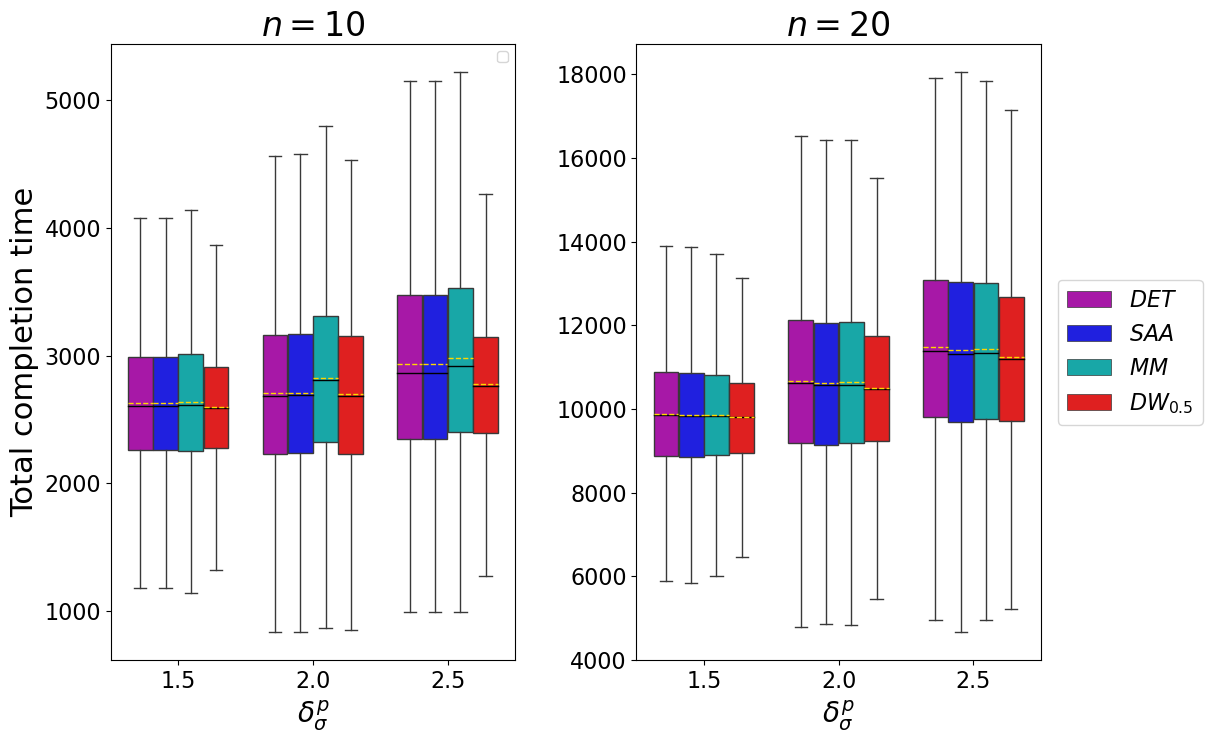

In [52]:
n_all = [10,20]
plot_group_box(df_final,n_all,'delta_ep')

# impact of mad_r

In [53]:
n = 10 # num of jobs
delta_mu = 4 # control lb of mean processing time
delta_r = 0.2 # control ub of the release time
delta_ep = 1.5 # control the upper bound of the mad
S_train = 30
S_test = 10000
iterations = 10


In [54]:
project_path = '/Users/zhangxun/Desktop/IJPR/det_release/sample_size_delta_r'

Seed = 70
it = 0
ins = 0
full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
tft_df = pd.read_csv(full_path+'tft.csv')

In [55]:
tft_df

,Unnamed: 0,det,saa,mom,wass_344.444356059078
0,0,3141.102963,3126.320051,3375.481439,2939.353616
1,1,3220.613292,3215.229479,3129.841991,3078.728909
2,2,2894.630735,2898.450438,2599.639676,2850.377515
3,3,3604.285944,3556.125173,3745.996159,2994.918009
4,4,3298.426104,3260.492132,2975.167515,3080.432138
...,...,...,...,...,...
9965,9965,2195.831867,2203.271820,2454.627698,2591.114558
9966,9966,1815.172935,1849.353031,2250.852555,2345.603396
9967,9967,2014.285512,1963.122164,2331.256438,2795.435185
9968,9968,4248.981188,4229.678009,3771.489519,3176.873745


In [10]:
[N_s,N_c] = np.shape(tft_df.values)

In [58]:
n_all = [10,15,20]
df_final = {}
for n in n_all:
    ins = 0
    Seed = 70 + ins
    df_set = {}
    delta_r_all = [0.05,0.1,0.2]
    for delta_r in delta_r_all:
        it = 0
        full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
        tft_df = pd.read_csv(full_path+'tft.csv')
        df = pd.DataFrame(np.zeros((N_s * 4,3)))
        col_vector = tft_df.columns.values
        col_names = [r'$DET$', r'$SAA$', r'$MM$',r'$DW_{0.5}$']
        col_vector = ['det', 'saa', 'mom',col_vector[4]]
        df.columns = ['tft','appro','delta_r']
        for i in range(4):
            df['tft'][i*N_s:(i+1)*N_s] = tft_df[col_vector[i]]
            df['appro'][i*N_s:(i+1)*N_s] = np.asarray([col_names[i] for ind in range(N_s)])
            df['delta_r'][i*N_s:(i+1)*N_s] = np.ones(N_s)*delta_r
        df_set[delta_r] = copy.deepcopy(df)
    df_final[n] = pd.concat([df_set[delta_r] for delta_r in delta_r_all])

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/2416611074.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_r'][i*N_s:(i+1)*N_s] = np.ones(N_s)*delta_r
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/2416611074.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tft'][i*N_s:(i+1)*N_s] = tft_df[col_vector[i]]
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/2416611074.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [16]:
df_final[n]

,tft,appro,delta_r
0,8647.279102,DET,0.05
1,7189.652661,DET,0.05
2,9751.720727,DET,0.05
3,11282.156715,DET,0.05
4,11309.365152,DET,0.05
...,...,...,...
39875,10396.872388,W=0.5,0.20
39876,9792.959015,W=0.5,0.20
39877,11803.745543,W=0.5,0.20
39878,10811.101199,W=0.5,0.20


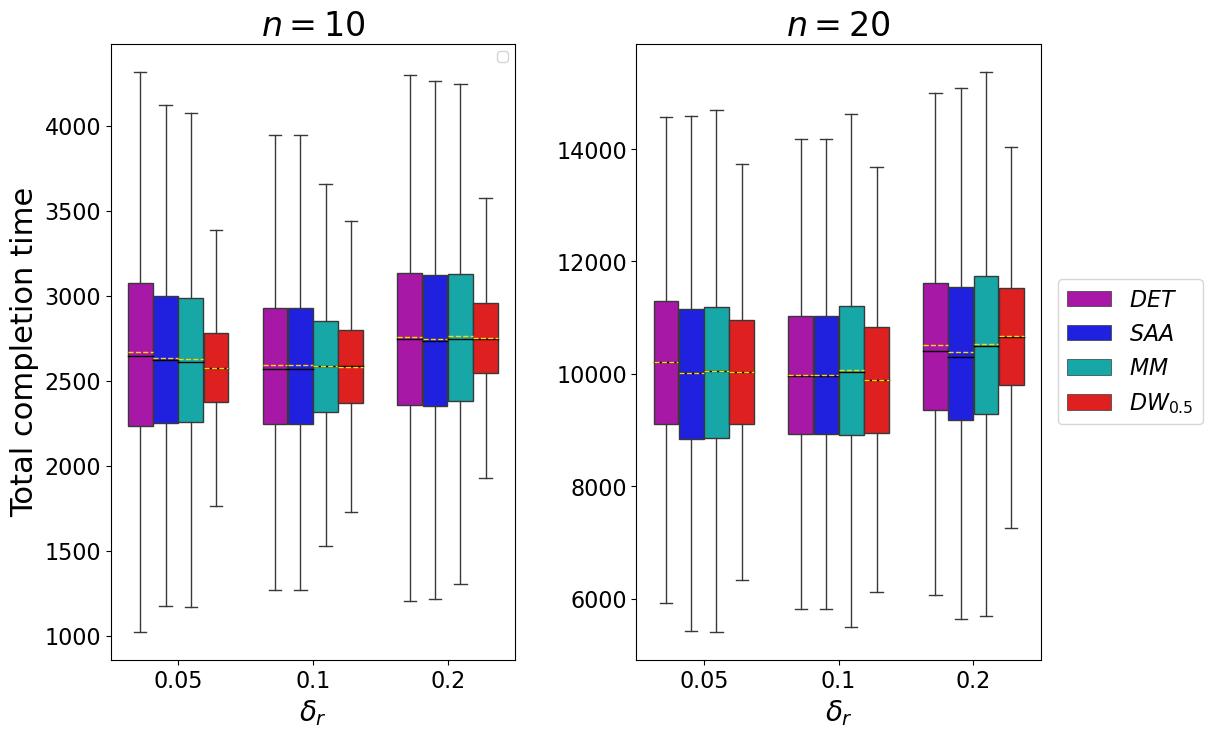

In [61]:
n_all = [10,20]
plot_group_box(df_final,n_all,'delta_r')

# cpu time

In [25]:
project_path = '/Users/zhangxun/Desktop/IJPR/random_release/rand/rand_cpu_time'
n = 10 # num of jobs
delta_mu = 4 # control lb of mean processing time
delta_r = 0.05 # control ub of the release time
delta_ep = 1.5 # control the upper bound of the mad
S_train = 30
S_test = 10000
iterations = 10
Seed = 0

In [30]:
ins = 0
it = 0
full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+\
    '/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep) + 'delta_mad_r=0.3'


In [36]:
full_path
with open(full_path+'cpu_time.pkl', "rb") as tf:
    cpu_time = pickle.load(tf)

In [37]:
cpu_time

array([0.00160289, 0.07864404, 0.15371227])

In [39]:
n_all = [10,15,20,25,30]
time_arr = np.zeros((5,3))
i = 0
for n in n_all:
    
    ins = 0
    Seed =ins
    df_set = {}
    delta_r_all = [0.05,0.1,0.2]
    
    it = 0
    full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+\
    '/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep) + 'delta_mad_r=0.3'
    with open(full_path+'cpu_time.pkl', "rb") as tf:
        cpu_time = pickle.load(tf)
    print(cpu_time)
    time_arr[i,:] = cpu_time
    # appro = ['det','saa','wass']


    # for j in range(len(appro)):
    #     if j != 3:
    #         time_arr[i,j] = cpu_time[appro[j]]
    #     else:
    #         time_arr[i,j] = cpu_time[appro[j]][0]
    i = i + 1

[0.00160289 0.07864404 0.15371227]
[0.00353503 0.07788062 0.34568119]
[0.00419807 0.20426106 0.89547706]
[0.00670815 1.12704992 1.66856694]
[0.01013279 1.47761488 2.65237403]


In [23]:
pd.DataFrame(time_arr).to_csv(project_path + '/data/cpu.csv')